## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...Done.


We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [2]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

## Loading and preparing training data
## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.


In [3]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
label_nums = {"label":{"male": 0, "female": 1}}
train_data = train_data.replace(label_nums)

data = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data.append([new_img_array, train_data['label'][i]])

In [4]:
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,/content/content/eye_gender_data/train/Image_1...,0
1,Image_2.jpg,/content/content/eye_gender_data/train/Image_2...,1
2,Image_3.jpg,/content/content/eye_gender_data/train/Image_3...,1
3,Image_4.jpg,/content/content/eye_gender_data/train/Image_4...,1
4,Image_5.jpg,/content/content/eye_gender_data/train/Image_5...,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9220 entries, 0 to 9219
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   9220 non-null   object
 1   filepaths  9220 non-null   object
 2   label      9220 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 608.1+ KB


In [6]:
X = []
y = []
for i in range(len(data)):
  X.append(data[i][0])
  y.append(data[i][1])

In [7]:
data_images = np.array(X)
image_labels = np.array(y)

In [9]:
data_images[:2]

array([[[188, 188, 189, ..., 176, 175, 175],
        [189, 189, 188, ..., 174, 173, 172],
        [190, 189, 188, ..., 168, 167, 167],
        ...,
        [133, 137, 144, ..., 168, 167, 166],
        [134, 138, 145, ..., 165, 164, 163],
        [135, 139, 146, ..., 163, 162, 162]],

       [[167, 169, 173, ..., 194, 195, 195],
        [168, 170, 173, ..., 193, 194, 195],
        [171, 171, 173, ..., 192, 193, 194],
        ...,
        [183, 185, 189, ..., 199, 197, 196],
        [183, 186, 189, ..., 199, 197, 195],
        [184, 186, 190, ..., 199, 196, 195]]], dtype=uint8)

In [10]:
image_labels[:5]

array([0, 1, 1, 1, 0])

In [11]:
train_images, test_images, train_labels, test_labels = train_test_split(
    data_images, image_labels, test_size=0.33, random_state=42)

class_names = ['male', 'female']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (6177, 100, 100), of uint8
Test_images.shape: (3043, 100, 100), of uint8


In [12]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 100, 100, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 100, 100, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (6177, 100, 100, 1), of uint8
Test_images.shape: (3043, 100, 100, 1), of uint8


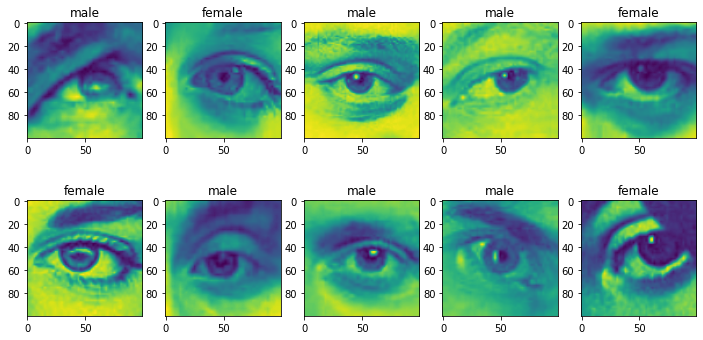

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5 
    ax[idx, idy].imshow(train_images_gr[i].reshape(100,100))
    ax[idx, idy].set_title(class_names[train_labels[i]])

## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [35]:
# define input shape
INPUT_SHAPE = (100, 100, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4333824   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [36]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
test_images_scaled = test_images_gr / 255.

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\n Accuracy > 98% stop training")
      self.model.stop_training = True

callbacks = myCallback()

history = model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[callbacks], 
                    epochs=EPOCHS,
                    validation_data=(test_images_scaled, test_labels),
                    verbose=1)

Epoch 1/100
194/194 [==============================] - 45s 229ms/step - loss: 0.5499 - accuracy: 0.7110 - val_loss: 0.4378 - val_accuracy: 0.8022
Epoch 2/100
194/194 [==============================] - 45s 230ms/step - loss: 0.3778 - accuracy: 0.8334 - val_loss: 0.3554 - val_accuracy: 0.8478
Epoch 3/100
194/194 [==============================] - 45s 230ms/step - loss: 0.3064 - accuracy: 0.8745 - val_loss: 0.3051 - val_accuracy: 0.8735
Epoch 4/100
194/194 [==============================] - 44s 229ms/step - loss: 0.2615 - accuracy: 0.8943 - val_loss: 0.3018 - val_accuracy: 0.8728
Epoch 5/100
194/194 [==============================] - 44s 229ms/step - loss: 0.2157 - accuracy: 0.9095 - val_loss: 0.2654 - val_accuracy: 0.8922
Epoch 6/100
194/194 [==============================] - 44s 229ms/step - loss: 0.1887 - accuracy: 0.9229 - val_loss: 0.3017 - val_accuracy: 0.8840
Epoch 7/100
194/194 [==============================] - 44s 229ms/step - loss: 0.1576 - accuracy: 0.9357 - val_loss: 0.2449 -

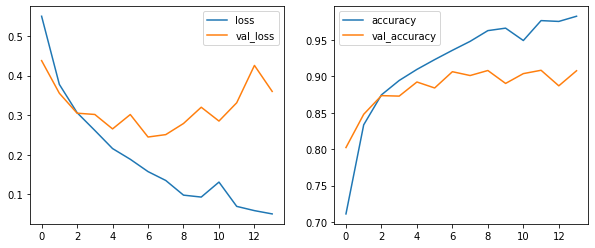

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Validate the model


In [39]:
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[9.9996471e-01, 3.5340141e-05],
       [7.2982721e-06, 9.9999273e-01],
       [9.9952793e-01, 4.7202941e-04],
       [9.9998176e-01, 1.8212426e-05],
       [9.9999833e-01, 1.6943932e-06]], dtype=float32)

In [40]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([0, 1, 0, 0, 0])

In [41]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

        male       0.92      0.92      0.92      1676
      female       0.90      0.90      0.90      1367

    accuracy                           0.91      3043
   macro avg       0.91      0.91      0.91      3043
weighted avg       0.91      0.91      0.91      3043



,male,female
male,1536,140
female,141,1226


## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

In [42]:
df_test = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/test/' + fname] for fname in df_test['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_data = pd.merge(images,df_test, how = 'inner', on = 'filename')

data_testing = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
for i in range(len(test_data)):
  img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data_testing.append(new_img_array)

## Data Pre-processing on test_data


In [43]:
testing_images = np.array(data_testing)
testing_images[:5]

array([[[140, 141, 142, ..., 169, 171, 173],
        [138, 138, 138, ..., 166, 168, 170],
        [137, 135, 134, ..., 163, 164, 166],
        ...,
        [146, 150, 155, ..., 151, 151, 151],
        [146, 151, 157, ..., 148, 147, 146],
        [147, 152, 158, ..., 147, 145, 143]],

       [[165, 168, 173, ...,  93,  89,  87],
        [160, 163, 169, ...,  89,  86,  84],
        [153, 156, 162, ...,  83,  80,  78],
        ...,
        [111, 113, 116, ..., 122, 120, 119],
        [111, 112, 115, ..., 125, 122, 121],
        [110, 112, 115, ..., 127, 124, 122]],

       [[208, 206, 204, ..., 184, 186, 187],
        [207, 206, 204, ..., 182, 184, 185],
        [206, 206, 204, ..., 179, 181, 181],
        ...,
        [211, 212, 214, ..., 222, 222, 222],
        [210, 212, 214, ..., 221, 221, 221],
        [210, 211, 214, ..., 221, 221, 221]],

       [[ 45,  43,  41, ..., 183, 180, 177],
        [ 35,  34,  32, ..., 181, 179, 177],
        [ 21,  21,  21, ..., 177, 178, 177],
        ..

In [44]:
print('Testing_images.shape: {}, of {}'.format(testing_images.shape, test_images.dtype))

Testing_images.shape: (2305, 100, 100), of uint8


In [45]:
testing_images_gr = testing_images.reshape(testing_images.shape[0], 100, 100, 1)

print('Testing_images.shape: {}, of {}'.format(testing_images_gr.shape, testing_images_gr.dtype))

Testing_images.shape: (2305, 100, 100, 1), of uint8


### Make Prediction on Test Dataset
Time to make a submission!!!

In [46]:
testing_images_scaled = testing_images_gr / 255.

In [47]:
predictions_test = model.predict(testing_images_scaled)
predictions[:5]

array([[9.9996471e-01, 3.5340141e-05],
       [7.2982721e-06, 9.9999273e-01],
       [9.9952793e-01, 4.7202941e-04],
       [9.9998176e-01, 1.8212426e-05],
       [9.9999833e-01, 1.6943932e-06]], dtype=float32)

In [48]:
predictions_test_labels = np.argmax(predictions_test, axis=1)
predictions_test_labels[:5]

array([0, 0, 0, 0, 0])

In [49]:
res = pd.DataFrame({'label': predictions_test_labels}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data

In [50]:
label_cat = {"label":{0 : "male", 1 :"female"}}
res = res.replace(label_cat)
res

,label
0,male
1,male
2,male
3,male
4,male
...,...
2300,female
2301,female
2302,male
2303,male


## **How to save prediction results locally via colab notebook?**
If you are working on Google Colab Notebook, execute below block of codes. A file named 'prediction_results' will be downloaded in your system.

In [51]:
res.to_csv("submission.csv", index = False)

# # To download the csv file locally
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>